First, imports

In [1]:
# Some fairly standard modules
import os, csv, lzma
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime

# The geopandas module does not come standard with anaconda,
# so you'll need to run the anaconda prompt as an administrator
# and install it via "conda install -c conda-forge geopandas".
# That installation will include pyproj and shapely automatically.
# These are useful modules for plotting geospatial data.
import geopandas as gpd
import pyproj
import shapely.geometry

# These modules are useful for tracking where modules are
# imported from, e.g., to check we're using our local edited
# versions of open_cp scripts.
import sys
import inspect
import importlib

# In order to use our local edited versions of open_cp
# scripts, we insert the parent directory of the current
# file ("..") at the start of our sys.path here.
sys.path.insert(0, os.path.abspath(".."))

# Seed np.random
np.random.seed(1)

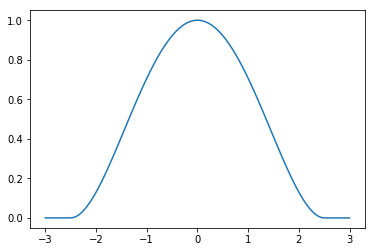

In [2]:
tau = 2.5

# Let x consist of 100 evenly-spaced points from -3 to 3
x = np.linspace(-3, 3, 100)

# 
y = (1 - (abs(x) / tau) ** 2) ** 2

# If x is less than -tau or greater than tau, set y to 0
y = y * (abs(x) < tau)

# Plot the graph
_ = plt.plot(x,y)

Improt retrospective hotspotting module from open_cp

In [3]:
import open_cp
import open_cp.retrohotspot as rhs

Generating random data

In [4]:
# Number of random points to generate
size = 30

# Range of coordinates for points
xmin = 0
xmax = 500
ymin = xmin
ymax = xmax

# Generate random dates from 2017 March 10-19 inclusive
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(size)]

# Sort those dates chronologically (I guess why not?)
times.sort()

# x and y coordinates are independently random float64's from 0 to 500
xc = (np.random.random(size=size)+xmin) * (xmax-xmin)
yc = (np.random.random(size=size)+ymin) * (ymax-ymin)

# Create TimedPoints objects from list of times, list of x-coords, list of y-coords
points = open_cp.TimedPoints.from_coords(times, xc, yc)

# Define RectangularRegion for points to lie in
region = open_cp.RectangularRegion(xmin,xmax, ymin,ymax)



Create predictor from points and region

In [5]:
# Instantiate predictor object of type RetroHotSpot
predictor = rhs.RetroHotSpot()
# Feed it our points as data
predictor.data = points
# Provide it a quartic weight function with desired bandwidth
bandwidth = 100
predictor.weight = rhs.Quartic(bandwidth)
# Generate prediction
prediction = predictor.predict()

This produces a relatively smooth visualization from risk calculated at every intersection point of an n x n grid (offset by 1/2). E.g., if the x/y coords ranged from 0 to 100, and the "size" were 10, then risk would be calculated at these 100 points: (5,5), (5, 15), ..., (5, 95), (15, 5), (15, 15), ... (95, 95). If instead the size were 5, then the step size would be 20, and risk would only be calculated at these 25 points: (10, 10), (10, 30), ... (10, 90), (30, 10), ..., (90, 90).

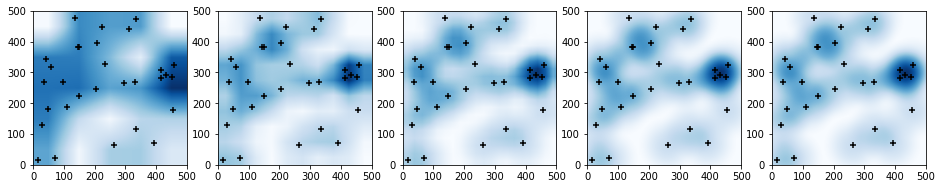

In [17]:
image_size_tests = [5,10,20,50,100]

fig, ax = plt.subplots(ncols=len(image_size_tests), figsize=(16,10))

for figctr, image_size in enumerate(image_size_tests):
    #image_size = 100
    density = np.empty((image_size, image_size))
    for i in range(image_size):
        for j in range(image_size):
            density[j][i] = prediction.risk((i + 0.5) / image_size * 500, (j + 0.5) / image_size * 500)


    ax[figctr].imshow(density, 
              cmap="Blues", 
              extent=(xmin,xmax,ymin,ymax), 
              origin="bottom", 
              interpolation="bilinear") # bilinear interpolation causes smoothing between adjacent points
    ax[figctr].scatter(points.xcoords, points.ycoords, marker="+", color="black")
    ax[figctr].set(xlim=[xmin, xmax], ylim=[ymin, ymax])

None